# Home 3: Build a CNN for image recognition.

### Name: Weronika Zamlynny

I pledge my honor that I have abided by the Stevens Honor System.


## 0. You will do the following:

1. Read, complete, and run my code.

2. **Make substantial improvements** to maximize the accuracy.
    
3. Convert the .IPYNB file to .HTML file.

    * The HTML file must contain the code and the output after execution.
    
4. Upload this .HTML file to your Github repo.

4. Submit the link to this .HTML file to Canvas.

    * Example: https://github.com/wangshusen/CS583A-2019Spring/blob/master/homework/HM3/cnn.html


## 1. Data preparation

### 1.1. Load data


In [1]:
from keras.datasets import cifar10
import numpy

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print('shape of x_train: ' + str(x_train.shape))
print('shape of y_train: ' + str(y_train.shape))
print('shape of x_test: ' + str(x_test.shape))
print('shape of y_test: ' + str(y_test.shape))
print('number of classes: ' + str(numpy.max(y_train) - numpy.min(y_train) + 1))

Using TensorFlow backend.


170500096/170498071 [==============================] - 25s 0us/step
shape of x_train: (50000, 32, 32, 3)
shape of y_train: (50000, 1)
shape of x_test: (10000, 32, 32, 3)
shape of y_test: (10000, 1)
number of classes: 10


In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

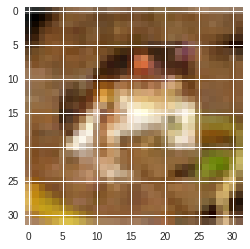

In [3]:
# View what the data is
plt.imshow(x_train[0])

### 1.2. One-hot encode the labels

In the input, a label is a scalar in $\{0, 1, \cdots , 9\}$. One-hot encode transform such a scalar to a $10$-dim vector. E.g., a scalar ```y_train[j]=3``` is transformed to the vector ```y_train_vec[j]=[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]```.

1. Define a function ```to_one_hot``` that transforms an $n\times 1$ array to a $n\times 10$ matrix.

2. Apply the function to ```y_train``` and ```y_test```.

In [0]:
import numpy as np

In [5]:
def to_one_hot(y, num_class=10):
    temp = np.zeros((y.shape[0], num_class))
    for i, val in enumerate(y):
        # val is still an array of one element
        temp[i, val[0]] = 1
    return temp

y_train_vec = to_one_hot(y_train)
y_test_vec = to_one_hot(y_test)

print('Shape of y_train_vec: ' + str(y_train_vec.shape))
print('Shape of y_test_vec: ' + str(y_test_vec.shape))

print(y_train[0])
print(y_train_vec[0])

Shape of y_train_vec: (50000, 10)
Shape of y_test_vec: (10000, 10)
[6]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


#### Remark: the outputs should be
* Shape of y_train_vec: (50000, 10)
* Shape of y_test_vec: (10000, 10)
* [6]
* [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]

### 1.3. Randomly partition the training set to training and validation sets

Randomly partition the 50K training samples to 2 sets:
* a training set containing 40K samples
* a validation set containing 10K samples


In [6]:
rand_indices = numpy.random.permutation(50000)
train_indices = rand_indices[0:40000]
valid_indices = rand_indices[40000:50000]

x_val = x_train[valid_indices, :]
y_val = y_train_vec[valid_indices, :]

x_tr = x_train[train_indices, :]
y_tr = y_train_vec[train_indices, :]

print('Shape of x_tr: ' + str(x_tr.shape))
print('Shape of y_tr: ' + str(y_tr.shape))
print('Shape of x_val: ' + str(x_val.shape))
print('Shape of y_val: ' + str(y_val.shape))

Shape of x_tr: (40000, 32, 32, 3)
Shape of y_tr: (40000, 10)
Shape of x_val: (10000, 32, 32, 3)
Shape of y_val: (10000, 10)


### Added: Data Augmentation

In [0]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(featurewise_center=False,
                                   samplewise_center=False, 
                                   featurewise_std_normalization=False, 
                                   samplewise_std_normalization=False, 
                                   zca_whitening=False, 
                                   zca_epsilon=1e-06, 
                                   rotation_range=45, # changed 
                                   width_shift_range=0.1, # changed 
                                   height_shift_range=0.1, # changed
                                   brightness_range=None, 
#                                    shear_range=0.1, # change 
#                                    zoom_range=0.1, # changed 
                                   channel_shift_range=0.0, 
                                   fill_mode='nearest', 
                                   cval=0.0, 
                                   horizontal_flip=True, # changed 
#                                    vertical_flip=True,  # changed
                                   rescale=None, # The images are already tiny 
                                   preprocessing_function=None, 
                                   data_format=None, 
                                   validation_split=0.0, 
                                   dtype=None)

train_datagen.fit(x_tr)
train_generator = train_datagen.flow(x_tr, y_tr, batch_size=32)

(32, 32, 32, 3) (32, 10)
Category [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


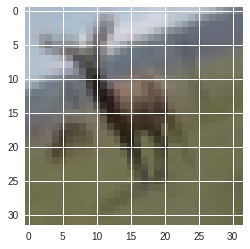

Category [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


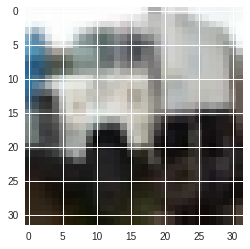

Category [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


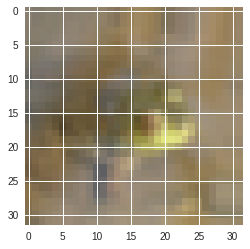

In [8]:
# View some generated images
for (x, y) in train_generator:
  print(x.shape, y.shape)
  for i in range(min(x.shape[0],3)):
    print("Category {}".format(y[i]))
    plt.imshow(x[i].astype(int))
    plt.show()
  break

## 2. Build a CNN and tune its hyper-parameters

1. Build a convolutional neural network model
2. Use the validation data to tune the hyper-parameters (e.g., network structure, and optimization algorithm)
    * Do NOT use test data for hyper-parameter tuning!!!
3. Try to achieve a validation accuracy as high as possible.

### Remark: 

The following CNN is just an example. You are supposed to make **substantial improvements** such as:
* Add more layers.
* Use regularizations, e.g., dropout.
* Use batch normalization.

In [21]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from keras.models import Sequential

model = Sequential()

# 32 filters each 3x3
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
# model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))


model.add(Dropout(0.2))
# 64 filters each 3x3
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
# model.add(MaxPooling2D((2, 2)))


model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

# Add a dropout layer here - next layer has many parameters
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
# model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))


model.add(Flatten())

# Add a dropout layer here
model.add(Dropout(0.5))

# The previous layer has output size 2048
model.add(Dense(1024, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
__________

In [0]:
from keras import optimizers


learning_rate = 1E-3
batch_size = 64

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=learning_rate),
              metrics=['acc'])

In [13]:
history = model.fit_generator(train_datagen.flow(x_tr, y_tr, batch_size=batch_size), steps_per_epoch=len(x_tr) / batch_size, epochs=100, validation_data=(x_val, y_val))

## How to fit if not using data augmentation:
# history = model.fit(x_tr, y_tr, batch_size=64, epochs=100, validation_data=(x_val, y_val))

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
625/625 [==============================] - 41s 65ms/step - loss: 1.9946 - acc: 0.2973 - val_loss: 1.6682 - val_acc: 0.3903
Epoch 2/100
625/625 [==============================] - 35s 56ms/step - loss: 1.5570 - acc: 0.4400 - val_loss: 1.5314 - val_acc: 0.4597
Epoch 3/100
625/625 [==============================] - 34s 55ms/step - loss: 1.4112 - acc: 0.4973 - val_loss: 1.5763 - val_acc: 0.5023
Epoch 4/100
625/625 [==============================] - 34s 54ms/step - loss: 1.3170 - acc: 0.5368 - val_loss: 2.8593 - val_acc: 0.3351
Epoch 5/100
625/625 [==============================] - 36s 57ms/step - loss: 1.2445 - acc: 0.5663 - val_loss: 1.2030 - val_acc: 0.5837
Epoch 6/100
625/625 [==============================] - 34s 55ms/step - loss: 1.2071 - acc: 0.5816 - val_loss: 1.0429 - val_acc: 0.6425
Epoch 7/100
625/625 [==============================] - 33s 53ms/step - loss: 1.1490 - acc: 0.5999 - val_loss: 1.4168 - val_acc: 0.5562
Epoch 8

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


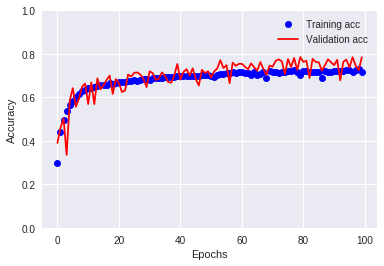

In [14]:
print(history.history.keys())

acc = history.history['acc']
val_acc = history.history['val_acc'] # This isn't here?

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.show()

## 3. Train (again) and evaluate the model

- To this end, you have found the "best" hyper-parameters. 
- Now, fix the hyper-parameters and train the network on the entire training set (all the 50K training samples)
- Evaluate your model on the test set.

### 3.1. Train the model on the entire training set

Why? Previously, you used 40K samples for training; you wasted 10K samples for the sake of hyper-parameter tuning. Now you already know the hyper-parameters, so why not using all the 50K samples for training?

In [0]:
from keras import backend
backend.clear_session()

# First run block to clear model, then re-run model definition from above, then continue

In [0]:
# <Compile your model again (using the same hyper-parameters)>
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=learning_rate),
              metrics=['acc'])

In [23]:
# <Train your model on the entire training set (50K samples)>
# <Use (x_train, y_train_vec) instead of (x_tr, y_tr)>
# <Do NOT use the validation_data option (because now you do not have validation data)>

history = model.fit_generator(train_datagen.flow(x_train, y_train_vec, batch_size=batch_size), steps_per_epoch=len(x_train) / batch_size, epochs=100)
# history = model.fit(x_train, y_train_vec, batch_size=batch_size, epochs=10)

Epoch 1/100
782/781 [==============================] - 46s 58ms/step - loss: 1.9181 - acc: 0.3049
Epoch 2/100
782/781 [==============================] - 45s 57ms/step - loss: 1.5388 - acc: 0.4434
Epoch 3/100
782/781 [==============================] - 44s 57ms/step - loss: 1.3890 - acc: 0.5074
Epoch 4/100
782/781 [==============================] - 44s 57ms/step - loss: 1.2812 - acc: 0.5501
Epoch 5/100
782/781 [==============================] - 45s 57ms/step - loss: 1.2044 - acc: 0.5800
Epoch 6/100
782/781 [==============================] - 44s 57ms/step - loss: 1.1452 - acc: 0.6032
Epoch 7/100
782/781 [==============================] - 44s 57ms/step - loss: 1.1026 - acc: 0.6158
Epoch 8/100
782/781 [==============================] - 45s 57ms/step - loss: 1.0671 - acc: 0.6301
Epoch 9/100
782/781 [==============================] - 44s 57ms/step - loss: 1.0515 - acc: 0.6390
Epoch 10/100
782/781 [==============================] - 44s 57ms/step - loss: 1.0366 - acc: 0.6458
Epoch 11/100
782/78

### 3.2. Evaluate the model on the test set

Do NOT used the test set until now. Make sure that your model parameters and hyper-parameters are independent of the test set.

In [24]:
loss_and_acc = model.evaluate(x_test, y_test_vec)
print('loss = ' + str(loss_and_acc[0]))
print('accuracy = ' + str(loss_and_acc[1]))

10000/10000 [==============================] - 3s 268us/step
loss = 0.7569259902477264
accuracy = 0.7763


### Final Test Accuracy: 0.7763
#### Final Comments:
- When testing different configurations, training without data augmentation gave better accuracies for both training and validation sets. However, the difference between them was great (training was around 90+% accuracy, and validation around 75% accuracy). This signified to me that there was a high change of overfitting, and it would be better to use data augmentation which results in fairly similar training and validation accuracies as they both grow.
- I also tested using a pre-trained model VGG16. This model without data augmentation had substantially better results (in many less epochs), but again showed signed of overfitting with training accuracy arounf 99% and validation around 75%. Adding data augmentation however, to this pretrained model gave worse results than the final model decided upon (in this document). Pre-training can be implemented as follows (since it is not used in this model):

        
        from keras.applications import VGG16

        conv_base = VGG16(weights='imagenet', include_top=False, 
                          input_shape=(32,32,3))

        trainable_layer_names = ['block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_pool']
        conv_base.trainable = True

        for layer in conv_base.layers:
          if layer.name in trainable_layer_names:
            layer.trainable = True
          else:
            layer.trainable = False

        conv_base.summary()

        ...

        model.add(conv_base)

        